In [1]:
from dask.distributed import Client
import dask.bag as db
import json
from collections import Counter
import time
import numpy as np
import pandas as pd
import s3fs
from PIL import Image


In [2]:
fs = s3fs.S3FileSystem(anon=True)
fs.ls('smithsonian-open-access')

['smithsonian-open-access/media', 'smithsonian-open-access/metadata']

In [3]:
metadata = fs.ls('smithsonian-open-access/metadata/edan')
metadata

['smithsonian-open-access/metadata/edan/acah',
 'smithsonian-open-access/metadata/edan/acm',
 'smithsonian-open-access/metadata/edan/cfchfolklife',
 'smithsonian-open-access/metadata/edan/chndm',
 'smithsonian-open-access/metadata/edan/fbr',
 'smithsonian-open-access/metadata/edan/fs',
 'smithsonian-open-access/metadata/edan/fsa',
 'smithsonian-open-access/metadata/edan/fsg',
 'smithsonian-open-access/metadata/edan/hac',
 'smithsonian-open-access/metadata/edan/hmsg',
 'smithsonian-open-access/metadata/edan/hsfa',
 'smithsonian-open-access/metadata/edan/naa',
 'smithsonian-open-access/metadata/edan/nasm',
 'smithsonian-open-access/metadata/edan/nmaahc',
 'smithsonian-open-access/metadata/edan/nmafa',
 'smithsonian-open-access/metadata/edan/nmah',
 'smithsonian-open-access/metadata/edan/nmai',
 'smithsonian-open-access/metadata/edan/nmnhanthro',
 'smithsonian-open-access/metadata/edan/nmnhbirds',
 'smithsonian-open-access/metadata/edan/nmnhbotany',
 'smithsonian-open-access/metadata/edan

In [4]:
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:49920 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 17.18 GB


In [5]:
b = db.read_text('s3://smithsonian-open-access/metadata/edan/saam/*.txt',
                storage_options={'anon': True}).map(json.loads)

In [6]:
saam_example = b.take(1)[0]
print(json.dumps(saam_example, indent=5))

{
     "id": "edanmdm-saam_1971.439.94",
     "version": "",
     "unitCode": "SAAM",
     "linkedId": "0",
     "type": "edanmdm",
     "content": {
          "descriptiveNonRepeating": {
               "record_ID": "saam_1971.439.94",
               "online_media": {
                    "mediaCount": 1,
                    "media": [
                         {
                              "thumbnail": "http://ids.si.edu/ids/deliveryService?id=SAAM-1971.439.94_1",
                              "idsId": "SAAM-1971.439.94_1",
                              "usage": {
                                   "access": "CC0"
                              },
                              "guid": "http://n2t.net/ark:/65665/bj992c82692-2156-4c18-afee-bd08d92b590a",
                              "type": "Images",
                              "content": "http://ids.si.edu/ids/deliveryService?id=SAAM-1971.439.94_1",
                              "resources": [
                                   {
  

In [11]:
from IPython.display import display, JSON

In [12]:
display(JSON(saam_example, expanded=True))

<IPython.core.display.JSON object>

In [7]:
def flatten(record):
    flattened_record = dict()
    flattened_record['id'] = record['id']
    flattened_record['unitCode'] = record['unitCode']
    flattened_record['title'] = record['title']
    media_count = record['content'].get('descriptiveNonRepeating', {}).get('online_media',{}).get('mediaCount',np.nan)
    flattened_record['media_count'] = float(media_count)
    media = record['content'].get('descriptiveNonRepeating', {}).get('online_media',{}).get('media',[])   
    if len(media):
        flattened_record['media_id'] = media[0]['idsId']
        
    topics = record['content'].get('indexedStructured',{}).get('topic',[])
    if len(topics):
        flattened_record['topics'] = '|'.join(topics)
    
    if 'freetext' in record['content']:
        if 'objectType' in record['content']['freetext']:
            for obtype in record['content']['freetext']['objectType']:
                if obtype['label'] == 'Type':
                    flattened_record['object_type'] = obtype['content']
        if 'physicalDescription' in record['content']['freetext']:
            for phys in record['content']['freetext']['physicalDescription']:
                if phys['label'] == 'Medium':
                    flattened_record['medium'] = phys['content']
    return flattened_record

In [8]:
flattened_example = flatten(saam_example)
flattened_example

{'id': 'edanmdm-saam_1971.439.94',
 'unitCode': 'SAAM',
 'title': 'Calavera for the Policeman',
 'media_count': 1.0,
 'media_id': 'SAAM-1971.439.94_1',
 'topics': 'Occupations|Service|Policeman|Skeleton',
 'object_type': 'Graphic Arts-Print',
 'medium': 'woodcut'}

In [9]:
saam_df = b.map(flatten).to_dataframe().compute()
saam_df.head()

,id,unitCode,title,media_count,media_id,topics,object_type,medium
0,edanmdm-saam_1971.439.94,SAAM,Calavera for the Policeman,1.0,SAAM-1971.439.94_1,Occupations|Service|Policeman|Skeleton,Graphic Arts-Print,woodcut
1,edanmdm-saam_1915.5.1,SAAM,The Falling Gladiator,1.0,SAAM-1915.5.1_1,Sport|Occupations|Nudity|State of being|Figure...,Sculpture,plaster
2,edanmdm-saam_1983.90.173,SAAM,The Sortie Made by the Garrison of Gibraltar i...,NaN,NaN,History,Graphic Arts-Print,engraving
3,edanmdm-saam_1985.66.295_540,SAAM,Ta-do-udo-sa (Prairie Chicken),1.0,SAAM-1985.66.295540_1,Ethnicity|Men|Portraits,Painting,oil on canvas
4,edanmdm-saam_1930.12.47,SAAM,Figure Study for Decorative Panel,1.0,SAAM-1930.12.47_1,Landscapes|Figure female|Nudity,Drawing,pencil and watercolor on paper mounted on pape...


In [10]:
saam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12542 entries, 0 to 59
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           12542 non-null  object 
 1   unitCode     12542 non-null  object 
 2   title        12542 non-null  object 
 3   media_count  11561 non-null  float64
 4   media_id     11561 non-null  object 
 5   topics       11230 non-null  object 
 6   object_type  12542 non-null  object 
 7   medium       12100 non-null  object 
dtypes: float64(1), object(7)
memory usage: 881.9+ KB


In [11]:
saam_df.groupby(['object_type','medium']).size().sort_values(ascending=False).head(20)

object_type             medium                          
Painting                oil on canvas                       1662
                        watercolor on paper                  853
Drawing                 pencil on paper                      642
Graphic Arts-Print      wood engraving on paper              441
Drawing                 drawing                              354
Painting-Miniature      watercolor on ivory                  350
Photography-Photoprint  albumen silver print                 268
Graphic Arts-Print      lithograph                           223
Decorative Arts-Glass   glass                                223
Graphic Arts-Print      etching on paper                     214
Sculpture               plaster                              209
Drawing                 pencil                               201
Graphic Arts-Print      etching                              194
Painting                watercolor                           149
Graphic Arts-Print      engraving

In [12]:
topic_list = []
topics_entries = saam_df['topics'].dropna().tolist()
for topics_entry in topics_entries:
    topics = topics_entry.split('|')
    if len(topics):
        topic_list += topics
print(len(topic_list))
topic_counts = Counter(topic_list)
topic_counts.most_common(20)

56927


[('Landscapes', 3368),
 ('Architecture', 2482),
 ('Portraits', 2459),
 ('Figure group', 2202),
 ('Men', 1988),
 ('Occupations', 1534),
 ('Ethnicity', 1375),
 ('Animals', 1354),
 ('Figure female', 1128),
 ('Women', 1062),
 ('Clothing and dress', 1003),
 ('Figure male', 814),
 ('Botanical study', 776),
 ('Religion', 751),
 ('Nudity', 707),
 ('Domestic', 704),
 ('Cityscapes', 625),
 ('Recreation', 558),
 ('Dress accessories', 554),
 ('Children', 517)]

In [13]:
include_topics = ['Landscapes','Architecture','Animals']
exclude_topics = ['Portraits','Nudity','Ethnicity','Men','Women','Children',
                'Figure male','Figure female','Figure group',
                 'Botanical study']
include_regex = '|'.join(include_topics)
exclude_regex = '|'.join(exclude_topics)
filtered_df = saam_df[(saam_df['topics'].str.contains(include_regex, regex=True).fillna(False)) & \
                 (~saam_df['topics'].str.contains(exclude_regex, regex=True).fillna(False))]
filtered_df.head()

,id,unitCode,title,media_count,media_id,topics,object_type,medium
6,edanmdm-saam_1929.6.144,SAAM,"The Brook, Greenwich, Connecticut",1.0,SAAM-1929.6.144_1,Landscapes|Rivers|Greenwich,Painting,oil on canvas
20,edanmdm-saam_1991.56.271,SAAM,Nanfio,1.0,SAAM-1991.56.271_1,Mountains|Landscapes,Drawing,pencil on paper
21,edanmdm-saam_1998.160.3,SAAM,"Untitled from ""Atlantic and Great Western Rail...",NaN,NaN,Bridges|Atlantic and Great Western Railroad|Ra...,Photography-Photoprint,albumen silver print
25,edanmdm-saam_1983.83.171,SAAM,Rhine at the Lurlei,1.0,SAAM-1983.83.171_1,Lurlei|Landscapes|Art|Rhine River|Rivers,Drawing,pencil on paper
26,edanmdm-saam_1983.83.55,SAAM,Untitled (transfer drawing for Storm near Timb...,1.0,SAAM-1983.83.55_1,Trees|Western|Weather|Landscapes|Storms|Rocks,Drawing,pencil on paper


In [14]:
topic_list = []
topics_entries = filtered_df['topics'].dropna().tolist()
for topics_entry in topics_entries:
    topics = topics_entry.split('|')
    if len(topics):
        topic_list += topics
print(len(topic_list))
topic_counts = Counter(topic_list)
topic_counts.most_common(20)

14469


[('Landscapes', 1979),
 ('Architecture', 1177),
 ('Animals', 634),
 ('Mountains', 379),
 ('Rivers', 315),
 ('Trees', 291),
 ('Cityscapes', 276),
 ('Boats and boating', 258),
 ('Domestic', 253),
 ('Waterscapes', 231),
 ('Religion', 225),
 ('Detail', 189),
 ('Dwellings', 166),
 ('Birds', 164),
 ('Coasts', 141),
 ('Time', 125),
 ('Water', 122),
 ('Weather', 119),
 ('Seasons', 119),
 ('Roads', 112)]

In [15]:
painting_ids = filtered_df[filtered_df['object_type'] == 'Painting']['media_id'].dropna().tolist()
len(painting_ids)

808

In [16]:
painting_ids[:10]

['SAAM-1929.6.144_1',
 'SAAM-1967.136.6_1',
 'SAAM-1958.5.3_1',
 'SAAM-1984.50_2',
 'SAAM-1973.150_1',
 'SAAM-1985.66.385_1',
 'SAAM-1909.7.51_1',
 'SAAM-1983.95.91_1',
 'SAAM-1972.2.12_1',
 'SAAM-1978.68_1']

In [17]:
!mkdir saam_thumbnails

mkdir: saam_thumbnails: File exists


In [18]:
def download_thumbnail(edan_id):
    thumb_size = (500, 500)
    s3_url = f'smithsonian-open-access/media/saam/{edan_id}.jpg'
    file_dest = f'saam_thumbnails/{edan_id}.jpg'
    with fs.open(s3_url,'rb') as s3_image:
        pil_image = Image.open(s3_image)
        pil_image.thumbnail(thumb_size)
        pil_image.save(file_dest)
    return

In [19]:
start = time.time()
futures = client.map(download_thumbnail, painting_ids)
results = client.gather(futures)
end = time.time()
print(end - start)

345.596914768219


In [13]:
import tensorflow as tf
from umap import UMAP
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

/Users/triznam/miniconda3/envs/siopenaccess/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
base = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet', pooling='avg')
mobilenet_model = tf.keras.Model(inputs=base.input, outputs=base.layers[-2].output)

In [23]:
def image_to_vector(image_path):
    pil_image = Image.open(image_path).resize((224,224), Image.ANTIALIAS)
    np_image = np.array(pil_image)
    np_image = np.expand_dims(np_image, axis=0)
    im = tf.keras.applications.mobilenet_v2.preprocess_input(np_image)
    vec = mobilenet_model.predict(im).squeeze()
    return vec

In [24]:
test_image_path = 'saam_thumbnails/SAAM-1909.11.2_1.jpg'
feature_vector = image_to_vector(test_image_path)
feature_vector

array([1.2039641 , 0.04013129, 0.31633848, ..., 0.17493182, 0.        ,
       0.7064775 ], dtype=float32)

In [25]:
image_dir = 'saam_thumbnails'
painting_image_paths = [f'{image_dir}/{edan_id}.jpg' for edan_id in painting_ids]
painting_image_paths[:5]

['saam_thumbnails/SAAM-1929.6.144_1.jpg',
 'saam_thumbnails/SAAM-1967.136.6_1.jpg',
 'saam_thumbnails/SAAM-1958.5.3_1.jpg',
 'saam_thumbnails/SAAM-1984.50_2.jpg',
 'saam_thumbnails/SAAM-1973.150_1.jpg']

In [26]:
start = time.time()
vectors = []
for image in painting_image_paths:
    vec = image_to_vector(image)
    vectors.append(vec)
vector_array = np.array(vectors)
end = time.time()
print(end - start)

43.484670877456665


In [27]:
vector_array.shape

(808, 1280)

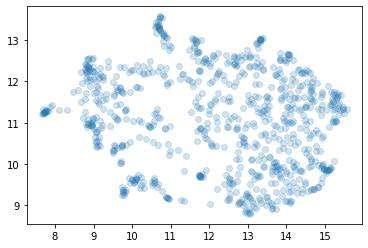

In [28]:
reducer = UMAP(random_state=42)

embedding = reducer.fit_transform(vector_array)

plt.scatter(embedding[:,0], embedding[:,1],
            alpha=0.2)

In [29]:
embedding_normalized = minmax_scale(embedding)

In [30]:
embedding_normalized[:5]

array([[0.837028  , 0.10463274],
       [0.8887067 , 0.68516624],
       [0.95835865, 0.6191939 ],
       [0.70636725, 0.5381254 ],
       [0.49375033, 0.88768566]], dtype=float32)

In [31]:
df = pd.DataFrame(embedding_normalized, index=painting_ids, columns = ['x','y'])
df.head()

,x,y
SAAM-1929.6.144_1,0.837028,0.104633
SAAM-1967.136.6_1,0.888707,0.685166
SAAM-1958.5.3_1,0.958359,0.619194
SAAM-1984.50_2,0.706367,0.538125
SAAM-1973.150_1,0.493750,0.887686


In [32]:
df.to_csv('saam_features.tsv', sep='\t')

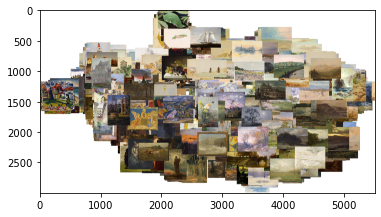

In [35]:
CANVAS_HEIGHT = 2500
CANVAS_WIDTH = 5000
canvas = np.full((CANVAS_HEIGHT+500,CANVAS_WIDTH+500,3),255, dtype=np.uint8)

THUMBNAIL_SIZE = 500,500

for row in df[::-1].itertuples():
    image_path = os.path.join(image_dir, row.Index) + '.jpg'
    x_pos = round(row.x * CANVAS_WIDTH)
    y_pos = CANVAS_HEIGHT - round(row.y * CANVAS_HEIGHT)

    pil_image = Image.open(image_path)
    pil_image.thumbnail(THUMBNAIL_SIZE)
    np_image = np.array(pil_image)
    canvas[y_pos:np_image.shape[0]+y_pos,
           x_pos:np_image.shape[1]+x_pos] = np_image    
plt.imshow(canvas)

In [36]:
saam_umap = Image.fromarray(canvas)
saam_umap.save('saam_umap.png')